In [1]:
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats.mstats import zscore
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
#from geopy import geocoders 
import scipy, json, csv, time
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('baseline_def_kaggle.csv')
df.head()

,Unnamed: 0,open,high,low,close,volume,market,close_ratio,spread,prevClose,2 Day Rolling Mean,2 Day SD,2 Day Volatility,percentChange,isEventBaseline
0,243,763.28,777.51,713.60,735.07,46862700.0,8.955395e+09,0.3359,63.91,735.07,731.45,5.119453,7.24,0.000000,False
1,244,737.98,747.06,705.35,727.83,32505800.0,8.869919e+09,0.5390,41.71,735.07,731.45,5.119453,7.24,-0.009849,False
2,245,728.05,748.61,714.44,745.05,19011300.0,9.082104e+09,0.8958,34.17,727.83,736.44,12.176379,17.22,0.023659,False
3,246,741.35,766.60,740.24,756.13,20707700.0,9.217168e+09,0.6028,26.36,745.05,750.59,7.834743,11.08,0.014871,False
4,247,760.32,760.58,738.17,754.01,20897300.0,9.191325e+09,0.7068,22.41,756.13,755.07,1.499066,2.12,-0.002804,False


In [10]:
#data = df[['open', 'high', 'close', 'volume', 'market', 'close_ratio', 'spread', 'percentChange']]
data = df[['close', 'percentChange', 'market']]
data.head()

,close,percentChange,market
0,735.07,0.000000,8.955395e+09
1,727.83,-0.009849,8.869919e+09
2,745.05,0.023659,9.082104e+09
3,756.13,0.014871,9.217168e+09
4,754.01,-0.002804,9.191325e+09


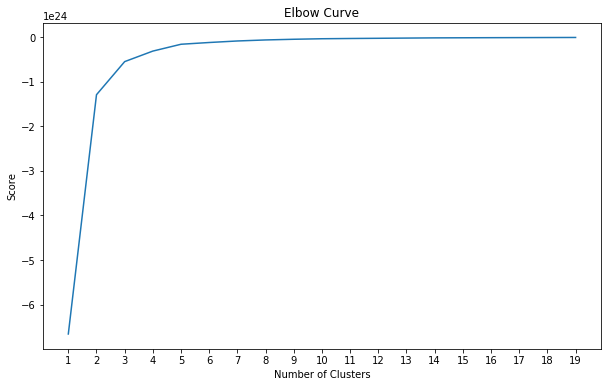

In [11]:
num_clusters = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in num_clusters]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(num_clusters, scores)
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

From this we can see the best number of clusters to use is 5

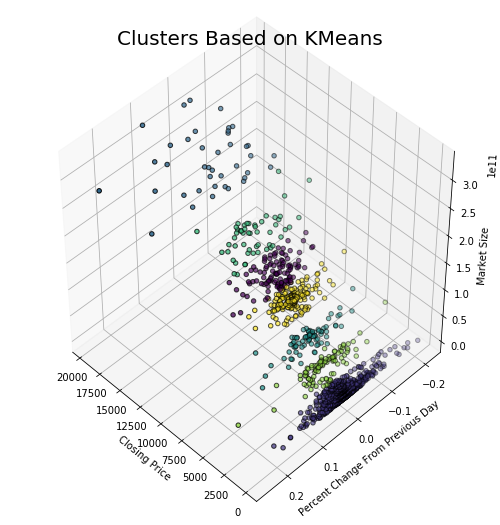

In [22]:
#Choosing the ebst number of clusters based on the elbow curve
best_num_cluster = 7
#X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
#X = X.reset_index(drop=True)
km = KMeans(n_clusters=best_num_cluster)
km.fit(data)
km.predict(data)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=45, azim=135)
ax.scatter(data.iloc[:,0], data.iloc[:,1], data.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("Closing Price")
ax.set_ylabel("Percent Change From Previous Day")
ax.set_zlabel("Market Size")
plt.title("Clusters Based on KMeans", fontsize=20);


Add in a shit ton of PCA

In [23]:
def pca_results(good_data, pca):
    # Using Rashid's function from visuals.py

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,10))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [30]:
def vis_PCA3D(color, colormap, title):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection="3d")
    # scatterplot of the reduced data    
    ax.scatter(xs=reduced_data[0], ys=reduced_data[1], zs=reduced_data[2], s=5, alpha=0.5, c=color, cmap=colormap)

    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.plot([0,arrow_size*v[0]], [0,arrow_size*v[1]], zs=[0,arrow_size*v[2]])
        ax.text(v[0]*text_pos, v[1]*text_pos, v[2]*text_pos, df.columns[i], color="black", ha="center", va="center", fontsize=10)

    ax.set_title("PC plane with original feature projections.", fontsize=16);
    ax
    plt.savefig(folderPath+"/vectors3DPer{0}.png".format(title), dpi = 300)

NOT 100% sure about feature_names

In [27]:
correlations = pd.DataFrame(data=data).corr()
feature_names = ['close', 'percentChange', 'market']

,Explained Variance,close,percentChange,market
Dimension 1,1.0,0.0,0.0,1.0
Dimension 2,0.0,1.0,0.0,-0.0
Dimension 3,0.0,-0.0,1.0,0.0


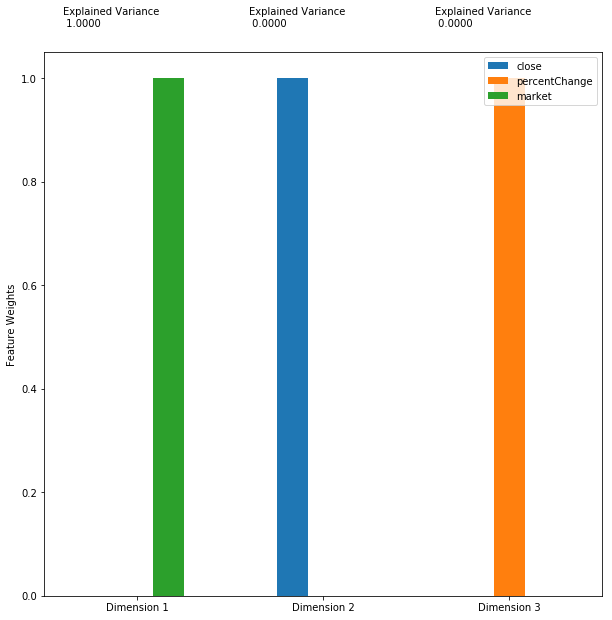

In [29]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=len(feature_names))
pca.fit(data)
reduced_data = pca.transform(data)
reduced_data = pd.DataFrame(reduced_data)
pca_results(correlations, pca)